In [1]:
#Get kaggle packages for easy import
!pip install kaggle

In [2]:
# Access google colab file system
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [3]:
# Download kaggle IEEE competition dataset
!kaggle competitions download -c ieee-fraud-detection

 72% 38.0M/52.5M [00:01<00:00, 20.0MB/s]
100% 52.5M/52.5M [00:01<00:00, 45.3MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.9MB/s]
 87% 41.0M/47.3M [00:01<00:00, 24.3MB/s]
100% 47.3M/47.3M [00:01<00:00, 33.8MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 98.6MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 165MB/s]


In [4]:
#Extract them all
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip
!unzip test_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip sample_submission.csv.zip

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   
Archive:  test_identity.csv.zip
  inflating: test_identity.csv       
Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [0]:
#Open each dataset as a dataframe
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
sub = pd.read_csv('sample_submission.csv')

In [0]:
# Merge Transactions and Identities data sets
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [0]:
#Lest give us some resources headroom
del train_identity, train_transaction, test_identity, test_transaction

In [9]:
# Verify shape of dataset
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [10]:
fraud = train.loc[train['isFraud']==1]
non_frauds = train.loc[train['isFraud']==0]
print(len(fraud))
print(len(non_frauds))

20663
569877


In [11]:
# See the highest fraud attempted, kinda ironic...
fraud['TransactionAmt'].max()

5191.0

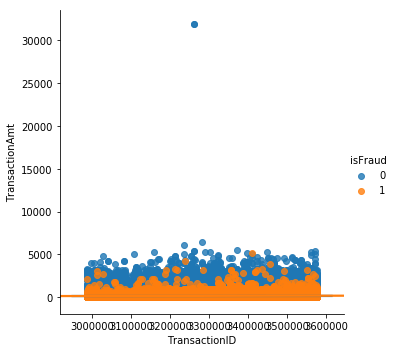

In [12]:
sns.lmplot(x='TransactionID', y='TransactionAmt', hue='isFraud', data=train)

<BarContainer object of 5 artists>

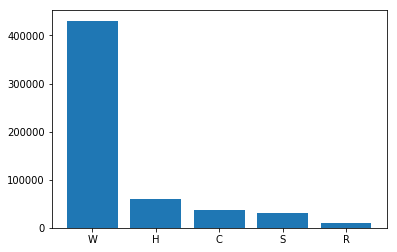

In [13]:
# plt.bar(fraud['ProductCD'].unique(),fraud['ProductCD'].value_counts())
plt.bar(non_frauds['ProductCD'].unique(),non_frauds['ProductCD'].value_counts())


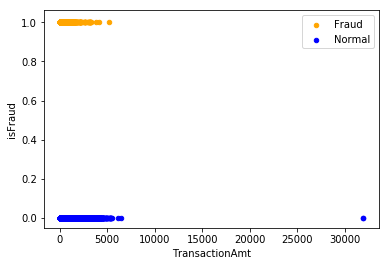

In [14]:
ax = fraud.plot.scatter(x='TransactionAmt', y='isFraud', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Blue', label='Normal', ax=ax)
plt.show()

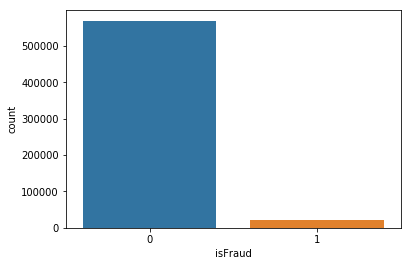

In [15]:
sns.countplot(x='isFraud', data=train)

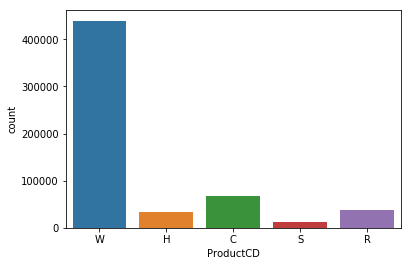

In [19]:
sns.countplot(x='ProductCD', data=train)

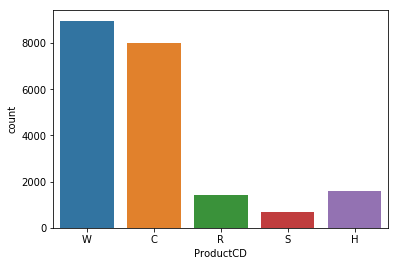

In [20]:
sns.countplot(x='ProductCD', data=fraud)

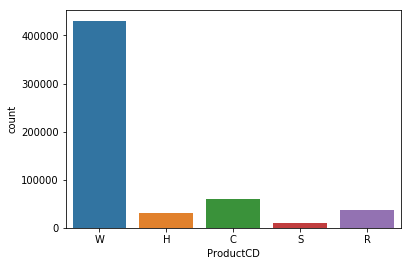

In [21]:
sns.countplot(x='ProductCD', data=non_frauds)

In [29]:
train_new = pd.DataFrame(train, columns=train.isnull().sum().sort_values()[:196].index)
train_new = train_new.drop(columns=['TransactionID', 'TransactionDT', 'card6', 'card4', 'P_emaildomain'])
train_new_label = train_new.isFraud
train_new = train_new.drop(columns=['isFraud'])
train_new.head()

,C14,C13,C12,C11,C10,C8,C7,C6,C5,C4,C3,C2,C1,C9,TransactionAmt,ProductCD,card1,V290,V306,V307,V308,V309,V310,V311,V312,V316,V317,V318,V319,V320,V305,V279,V285,V284,V291,V286,V321,V302,V299,V298,...,V56,V55,V54,V53,V71,D15,V84,V85,V75,V86,V87,V88,V89,V91,V92,V93,V94,V90,V82,V81,V80,V83,V79,V78,V77,V76,D4,V35,V36,V37,V38,V39,V40,V41,V49,V43,V44,V45,V46,V47
0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,68.5,W,13926,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,29.0,W,2755,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,59.0,W,4663,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,315.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,1.0,25.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,2.0,1.0,50.0,W,18132,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,50.0,1404.0,790.0,0.0,0.0,1.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,111.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,94.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,50.0,H,4497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# train_new = pd.DataFrame(train, columns=train.isnull().sum().sort_values()[:185].index)

In [31]:
train_new.shape

(590540, 190)

In [33]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_new['ProductCD'] = labelencoder.fit_transform(train_new['ProductCD'])
train_new.ProductCD[:5]

0    4
1    4
2    4
3    4
4    1
Name: ProductCD, dtype: int64

In [34]:
test_new = pd.DataFrame(test, columns=test.isnull().sum().sort_values()[:196].index)
test_new = test_new.drop(columns=['TransactionID', 'TransactionDT', 'card6', 'card4', 'P_emaildomain'])
test_new.head()

,V114,V113,V112,V111,V110,V109,V108,V107,V115,V106,V104,V103,V102,V101,V100,V99,V98,V97,V105,V96,V116,V118,V137,V136,V135,V134,V133,V132,V131,V130,V117,V129,V126,V125,V124,V123,V122,V121,V120,V119,...,V12,V55,V59,V53,V54,V56,V58,V65,V61,V62,V63,V64,V57,V66,V68,V67,V70,V71,V72,V73,V74,V69,V60,addr2,addr1,D4,V35,V36,V37,V38,V39,V43,V46,V47,V48,V49,V50,V51,V52,V44
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,47.950001,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,170.0,398.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,77.000000,280.000000,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,299.0,634.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,5.0,1.0,1.0,0.0,263.0,0.0,0.0,0.0,0.0,0.000000,705.000000,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,472.0,97.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,87.0,205.0,242.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,67.949997,183.850006,1.0,67.949997,67.949997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,87.0,264.0,22.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [35]:
test_new['ProductCD'] = labelencoder.fit_transform(test_new['ProductCD'])
test_new.ProductCD[:5]

0    4
1    4
2    4
3    4
4    4
Name: ProductCD, dtype: int64

In [0]:
train_new = train_new.fillna(-9999)
test_new = test_new.fillna(-9999)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_new, train_new_label, test_size=0.2)
lr = LogisticRegression(C=1e5)
lr = lr.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
from sklearn.metrics import accuracy_score

y_predict = lr.predict(x_test)
accuracy_score(y_predict, y_test)

0.9683001998171166

0.9683001998171166